## Assignment 1: Perceptron Training
Neural Networks and Computational Intelligence

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(29) # makes the random numbers predictable

In [20]:
## a) Generate artificial data sets
P = 5      # number of feature vectors 
N = 3      # dim of feature vectors

def datasets(N, P):
    D = np.zeros((N+1, P))       # empty data set (each column is a vector, last el. is the label)
    for mu in range(P):
        D[:-1, mu] = np.random.normal(0, 1, size=N)
        D[-1, mu] = np.random.randint(0, 2, size=1)        # the labels are 0 and 1 not -+1
        if D[-1, mu] == 0:
            D[-1, mu] = -1
    return D

D = datasets(N, P)
print(D)

[[-0.41748213 -2.1417555  -0.89422358  0.10193307  0.98494561]
 [ 0.7060321   0.23407402  0.80802964 -1.19332572 -1.1444064 ]
 [ 1.9159847   0.25027325 -0.20433129  0.00373976  0.38683645]
 [ 1.          1.          1.          1.         -1.        ]]


In [21]:
## c) Rosenblatt algorithm
def Ros_alg(N, P, D, n_max, inhomo= False, theta = 0, c_threshold=0, verbose=False):
    if inhomo:
        w = np.zeros(N+1)      # weight vector
        w[-1] = theta           # I think theta is initialized to  0 anyway 
    else:
        w = np.zeros(N)      # weight vector

    x = np.zeros(P) # embedding strengths
    E_mu = np.zeros(P)    # local potentials (one per input vector)
    n = 1
    #t = 0
    success = False
    while n <= n_max:
        #print('epoch', n)
        for mu in range(P):
            
            E_mu[mu] = np.dot(w, D[:-1, mu]) * D[-1, mu]
            
            heav = np.heaviside(c_threshold - E_mu[mu], 1) 
            
            if heav:
                w += 1/N * heav * D[:-1, mu] * D[-1, mu] 
                x[mu] += heav

        #t += 1
        if not np.any(E_mu <= 0):
            success = True
            break
        n += 1
        
    if verbose:
        print("Success: {} after {} out of {} max epochs".format(success, n, n_max))
        
    return w, x, n, success


In [22]:

n_max = 10
w, x, n, s = Ros_alg(N, P, D, n_max, verbose=True)

Success: True after 4 out of 10 max epochs


In [23]:
## Rosenblatt validation algorithm
def Ros_alg_theoretical(N, P, verbose=False):
    if P <= N:
        P_ls = 1
    else:
        P_ls = 0
        for ii in range(0, N):
            P_ls += np.math.factorial(P - 1) / (np.math.factorial(ii) * np.math.factorial(P - 1 - ii))
        P_ls *= 2**(1 - P)
        
    if verbose:
        print("P_ls of N = {}, P = {} -> {:.3f}".format(N, P, P_ls))
    
    return P_ls

a = Ros_alg_theoretical(N, P, verbose=True)

P_ls of N = 3, P = 5 -> 0.688


In [24]:
## d) Running the experiments PARALLEL

def do_experiment(alpha, N, n_D, n_max, inhomo = False, theta = 0, c_threshold=0.0, Theoretical = True):
    
    successful_runs = 0
    
    P = int(N * alpha)
    for dd in range(n_D):
        D = datasets(N, P) # new generated dataset
        ww, xx, nn, ss = Ros_alg(N, P, D, n_max, inhomo = False, theta = 0, c_threshold=c_threshold)    #I think I dont need w for anything
        successful_runs += ss

        P_ls = successful_runs / n_D
        
    if Theoretical:
        P_ls_theoretical = Ros_alg_theoretical(N, P) 
                
        return P_ls, P_ls_theoretical, alpha, N
    else:
        return P_ls, alpha, N


In [25]:
## d) Running the experiments IN  PARALLEL
from joblib import Parallel, delayed
import pandas as pd

def do_parallel(alpha, N_sizes, n_D, n_max, c_threshold=0.0, inhomo = False, theta = 0, Theoretical = True,  n_jobs = 8):
    # This needs to have all the combinations
    parameters = []
    for n in N_sizes:
        for a in alpha:
            parameters.append([a, n])

    if Theoretical:
        results = pd.DataFrame(columns=['P_ls', 'P_ls_theoretical', 'alpha', 'N'])

    else:
        results = pd.DataFrame(columns=['P_ls', 'alpha', 'N'])


    res = (Parallel(n_jobs = 8)(delayed(do_experiment)(al, n, n_D, n_max, inhomo, theta, c_threshold, Theoretical ) for  al, n in parameters))

    for i in res:
        results.loc[len(results)]=i
    return results



In [26]:
## Save and plot the results PARALLEL

def plot_save_results(results, N_sizes, name, Theoretical = True, save = True):
    if save:
        out_folder = "Results/"
        with open(out_folder + "Pls_{}.npy".format(name), 'wb') as f:
            np.save(f, results)
            #np.save(f, P_ls_theoretical)
    plot_lines = []
    plt.figure()
    colors = ["b", "r", "c", "g", "y", "m", "k"]
    for ii in range(len(N_sizes)):
        data = results.loc[results['N'] == N_sizes[ii]]
        if Theoretical:
            
            l1, =plt.plot(data['alpha'], data['P_ls'], colors[ii]+"-", label=N_sizes[ii])
            l2, =plt.plot(data['alpha'], data['P_ls_theoretical'], colors[ii]+"--")

            plot_lines.append([l1, l2])
        else:
            plt.plot(data['alpha'], data['P_ls'], colors[ii]+"-", label=N_sizes[ii])

    plt.xlabel(r'$\alpha$ = P/N')
    plt.ylabel('$Q_{ls}$ (Fraction of succesful runs)')
    plt.grid()
    if Theoretical:
        legend1 = plt.legend(plot_lines[0], ["$Q_{ls}$", "$P_{ls}$"], loc='lower left')
        plt.legend([l[0] for l in plot_lines], N_sizes, title = 'N', loc='upper right')
        plt.gca().add_artist(legend1)
    else:
        plt.legend(title = "N")
    plt.savefig("Results/Figures/Pls_{}.eps".format(name), format='eps')
    plt.savefig("Results/Figures/Pls_{}.png".format(name), format='png')
    plt.show()


In [27]:
min_alpha = 0.75; max_alpha = 3; step_alpha = 0.1
alpha = np.linspace(min_alpha, max_alpha, int(np.ceil((max_alpha - min_alpha) / step_alpha)))
N_sizes = [5, 20, 40]
n_D = 100 * 2   # number of random datasets for each P
n_max = 100      # max number of epochs 


#results_main = do_parallel(alpha, N_sizes, n_D, n_max)
#plot_save_results(results_main, N_sizes,  '1')



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


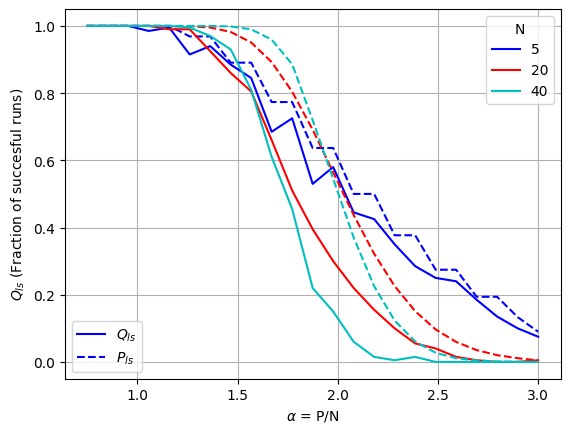

In [28]:
results_main = np.load("Results\Pls_1.npy")
results_main = pd.DataFrame(results_main, columns = ['P_ls', 'P_ls_theoretical', 'alpha', 'N'])

plot_save_results(results_main, N_sizes,  '1', save=False)

In [29]:
#Greater number of epochs
"""takes very long to run"""
min_alpha = 0.75; max_alpha = 3; step_alpha = 0.1
alpha = np.linspace(min_alpha, max_alpha, int(np.ceil((max_alpha - min_alpha) / step_alpha)))
N_sizes = [5, 20, 40]
n_D = 100 * 2   # number of random datasets for each P
n_max = 100 * 50     # max number of epochs 


#results_epochs = do_parallel(alpha, N_sizes, n_D, n_max, Theoretical=False)
#plot_save_results(results_epochs, N_sizes, "epochs", Theoretical = False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


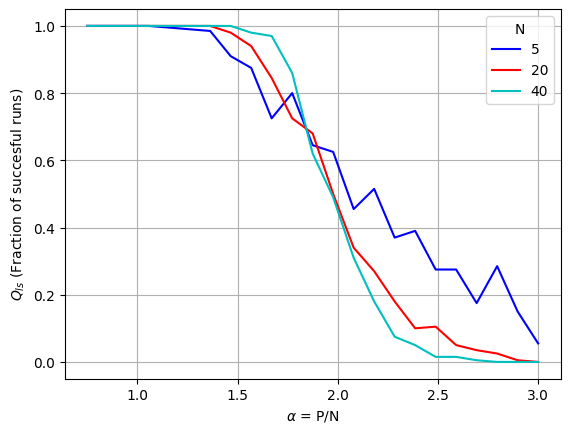

In [30]:
results_epochs = np.load("Results\Pls_epochs.npy")
results_epochs = pd.DataFrame(results_epochs, columns = ['P_ls', 'alpha', 'N'])

plot_save_results(results_epochs, N_sizes, "epochs", Theoretical = False, save=False)

In [31]:
## Bonus 1: Observe the behavior of Q_ls for different system sizes N
"""takes very long to run"""

min_alpha = 0.5; max_alpha = 2.5; step_alpha = 0.1
alpha = np.linspace(min_alpha, max_alpha, int(np.ceil((max_alpha - min_alpha) / step_alpha)))

N_sizes = [50, 100, 500, 1000, 2000]

n_D = 100   # number of random datasets for each P
n_max = 100     # max number of epochs 

#results_bonus1 = do_parallel(alpha, N_sizes, n_D, n_max, Theoretical=False)
#plot_save_results(results_bonus1, N_sizes,  "bonus1_2", Theoretical = False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


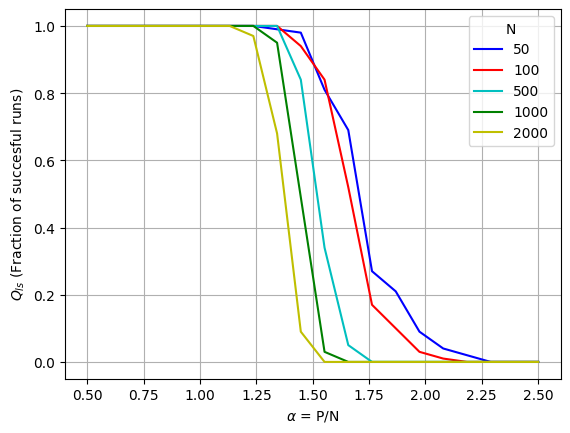

In [32]:
results_bonus1 = np.load("Results\Pls_bonus1_2.npy")
results_bonus1 = pd.DataFrame(results_bonus1, columns = ['P_ls', 'alpha', 'N'])

plot_save_results(results_bonus1, N_sizes,  'bonus1_2', Theoretical =False, save=False)

In [34]:
## Bonus 2: Embedding Strengths
P = 60
N = 30

n_D = 1  # you only do one experiment cause I doesnt make sense to sum xx from several
n_max = 100      # max number of epochs 

def do_experiment_emb(P, N, n_D, n_max, c_threshold=0.0):
    D = datasets(N, P) # new generated dataset
    ww, xx, nn, ss = Ros_alg(N, P, D, n_max, c_threshold=c_threshold)    #I think I dont need w for anything
    return xx

embedding_strengths= do_experiment_emb(P, N, n_D, n_max, c_threshold=0.0)



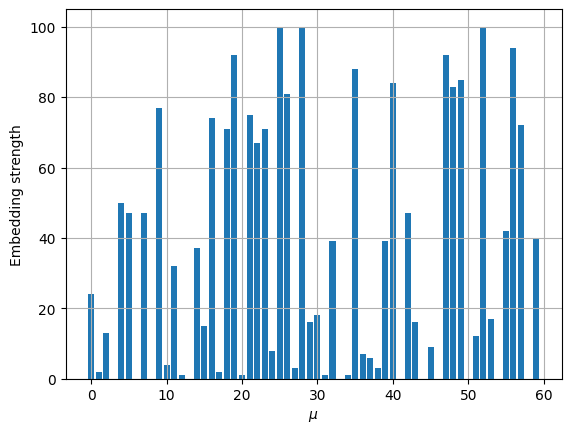

In [35]:
bins = np.arange(0, P, 1) 
plt.bar(bins, embedding_strengths)
plt.ylabel('Embedding strength')
plt.xlabel(r'$\mu$')
plt.grid()
plt.savefig("Results/Figures/Hist_embeddingS.eps", format='eps')
plt.savefig("Results/Figures/Hist_embeddingS.png", format='png')
plt.show()

In [36]:
## Bonus 3: Consider a non-zero value of c

min_alpha = 0.75; max_alpha = 3; step_alpha = 0.1
alpha = np.linspace(min_alpha, max_alpha, int(np.ceil((max_alpha - min_alpha) / step_alpha)))
N_sizes = [20]

n_D = 100*2   # number of random datasets for each P
n_max = 100*2     # max number of epochs
c_thresholds = [0, 0.1, 0.25, 0.5] 

results_bonus3 = pd.DataFrame(columns=['P_ls', 'P_ls_theoretical', 'alpha', 'N', 'c_thres'])


for cc in c_thresholds:
    c_thres = [cc for i in range(len(alpha)*len(N_sizes))]
    print("# C: {} out of {}".format(c_thresholds.index(cc) + 1, len(c_thresholds)))
    results_part = do_parallel(alpha, N_sizes, n_D, n_max, cc)
    results_part['c_thres'] = c_thres

    results_bonus3 = pd.concat([results_bonus3, results_part])
    

# C: 1 out of 4
# C: 2 out of 4
# C: 3 out of 4
# C: 4 out of 4


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


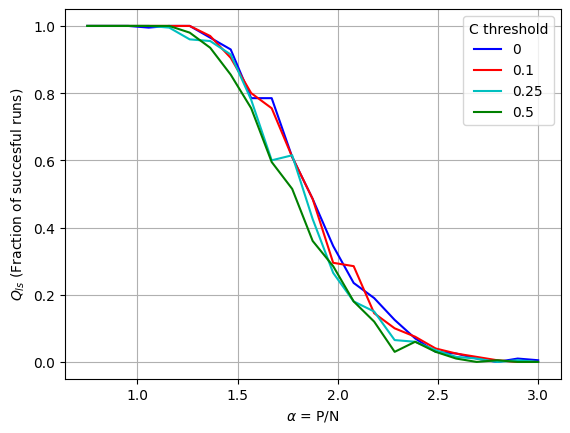

In [37]:
out_folder = "Results/"
with open(out_folder + "Pls_cthreshold.npy", 'wb') as f:
    for ii in range(len(c_thresholds)):
        #P_ls = results[ii]
        np.save(f, results_bonus3)
        
colors = ["b", "r", "c", "g", "y", "m", "k"]
plt.figure()
for ii in range(len(c_thresholds)):
    
    # plt.subplot(1, 1, ii + 1) # considering now only 1 N
    data = results_bonus3.loc[results_bonus3['c_thres'] == c_thresholds[ii]]
    
    plt.plot(data['alpha'], data['P_ls'], colors[ii]+"-", label=c_thresholds[ii])

plt.xlabel(r'$\alpha$ = P/N')
plt.ylabel('$Q_{ls}$ (Fraction of succesful runs)')
plt.grid()
plt.legend(title ="C threshold")
plt.savefig("Results/Figures/Pls_cthreshold.eps", format='eps')
plt.savefig("Results/Figures/Pls_cthreshold.png", format='png')
plt.show()

## Inhomogeneous perceptron

In [38]:
## Bonus 4:Generate artificial data sets for inhomogeneous perceptron
P = 5      # number of feature vectors 
N = 3      # dim of feature vectors

def datasets_inhomo(N, P):
    D = np.zeros((N+2, P))       # empty data set (each column is a vector, last el. is the label)
    for mu in range(P):
        D[:-2, mu] = np.random.normal(0, 1, size=N)
        D[-2, mu] = -1                                     #  extra dimension on the feature vector
        D[-1, mu] = np.random.randint(0, 2, size=1)        # the labels are 0 and 1 not -+1
        if D[-1, mu] == 0:
            D[-1, mu] = -1
    return D

D = datasets_inhomo(N, P)
print(D)

[[-1.27289838  0.03518122 -1.89030954 -0.52897963 -1.58997937]
 [-0.36663153  1.33969827  0.319985    0.48354574  2.02309299]
 [-0.11703121 -0.32935528 -0.40254944  0.88174654 -1.68210909]
 [-1.         -1.         -1.         -1.         -1.        ]
 [-1.          1.          1.          1.          1.        ]]


In [39]:
min_alpha = 0.75; max_alpha = 3; step_alpha = 0.1
alpha = np.linspace(min_alpha, max_alpha, int(np.ceil((max_alpha - min_alpha) / step_alpha)))
N_sizes = [5, 20, 40]
n_D = 100 *2  # number of random datasets for each P
n_max = 100  # max number of epochs 

#results_bonus4 = do_parallel(alpha, N_sizes, n_D, n_max, inhomo = True)
#plot_save_results(results_bonus4, N_sizes,  'inhomo_perceptron')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


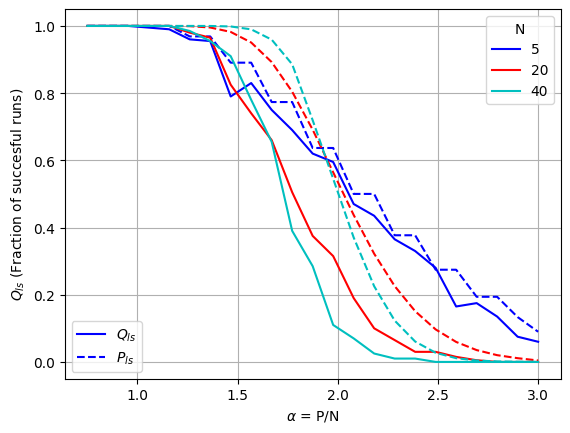

In [40]:
results_bonus4 = np.load("Results\Pls_inhomo_perceptron.npy")
results_bonus4 = pd.DataFrame(results_bonus4, columns = ['P_ls','P_ls_theoretical', 'alpha', 'N'])

plot_save_results(results_bonus4, N_sizes,  'inhomo_perceptron')
